# Gaussian Processes: priors

## From parameteric to nonparamteric models

So far, in this course, all models we have built were regressions, working in the supervised learning setting and using parametric models. We tried to describe functions with unknown parameters using Bayesian formalism.



Gaussian processes (GPs) are powerful and flexible statistical models used primarily in machine learning and statistics for regression and classification tasks. At its core, a Gaussian process is a collection of random variables, any <font color='orange'>finite subset</font> of which has a <font color='orange'>joint Multivariate</font> distribution. In simpler terms, a GP defines a <font color='orange'>distribution over functions</font> rather than individual points.

<font color='orange'>Nonparametric</font> models are statistical models where the number of parameters grows with the size of the dataset or is not fixed beforehand. This allows them to flexibly capture complex patterns in the data without making strong assumptions about the underlying distribution.

A Gaussian process is a <font color='orange'>nonparametric</font> model because it doesn't fix the number of parameters a priori, instead, it defines a distribution over functions, allowing for flexibility and adaptability to the complexity of the data.

A few key points about Gaussian processes:

- **Function Space Representation**: Unlike parametric models, which learn a fixed number of parameters, Gaussian processes define a distribution over functions. This allows them to capture uncertainty about the function being modeled.

```{margin}
Well, do assume *something* about the functions, e.g. their smoothness in the form of kernel choice. 
```
- **Flexibility**: GPs can model a wide variety of functions without assuming a specific functional form. This makes them particularly useful when dealing with complex or unknown relationships in data.

- **Bayesian Framework**: Gaussian processes are inherently Bayesian models, meaning they provide a principled way to quantify uncertainty in predictions. This is achieved by representing the posterior distribution over functions given the observed data.

- **Kernel Functions**: The choice of kernel function determines the behavior and characteristics of the GP. Common kernel functions include the radial basis function (RBF), also known as the squared exponential kernel, and the Matérn kernel, among others. These kernels encode assumptions about the smoothness and structure of the underlying function. We will see specific examples of kernels in this lecture.

- **Regression and Classification**: GPs can be used for both regression and classification tasks where GP is commonly used as a <font color='orange'>latent variable</font>.

- **Computational Considerations**: While GPs offer many advantages, they can be computationally intensive, especially as the size of the dataset grows. Various approximation methods such as sparse GPs and approximate inference techniques are used to scale Gaussian processes to larger datasets.

Now let's build the inredients which we need to understand Gaussian processes step by step.

## From Univariate to Multivariate Gaussians

### Univariate Normal distribution
```{margin}
In the chapter about distributions we used notation $X$ for a random variable and $x$ for its values. Here we will denote the random variable of interest $Y$. It will become clear soon why we need to do it.
```

Recall from previous chapters, the Univaritae normal distribution with PDF

$$
\mathcal{N}(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right).
$$

To show that variable $y$ is dustributed normally with mean $\mathbb{E}[y] = \mu$ and variance $\text{Var}(y)=\sigma^2$, we use notation 
$$y \sim \mathcal{N}(\mu, \sigma^2).$$


### Univariate reparametrization

Note, that in order to sample variable $y$ we could fisrt sample from a standard Normal variable $z \sim \mathcal{N}(0,1)$, and then perform a transformation of this variable 
$$
y = \mu + \sigma z \sim \mathcal{N}(\mu, \sigma^2).
$$

**Excersise**: prove that $\mu + \sigma z$ is indeed distributed as $\mathcal{N}(\mu, \sigma^2).$

### Multivariate Normal distribution

In the multivariate case, instead of using scalar mean and variance parameters $\mu, \sigma^2 \in \mathbb{R}$, we need to specify a vector mean $\mu \in \mathbb{R}^d$ and covariance matrix $\Sigma \in \mathbb{R}^{d \times d}.$ To write that variable $y$ follows a Multivariate Normal distribution, we use notation 
$$y \sim \mathcal{N}(\mu, \Sigma).$$

### Cholesky decomposition and reparametrization

Cholesky decomposition is a numerical method used to decompose a positive definite matrix into a lower triangular matrix and its conjugate transpose. For a positive definite matrix $A$, the Cholesky decomposition expresses it as:
$$A = L L^T$$
where
- $L$ is a lower triangular matrix,
- $L^T$ is the transpose of $L$.

Cholesky decomposition is particularly useful because it provides a computationally efficient way to solve linear systems of equations, including inverting matrices and calculating determinants, especially when the matrix is symmetric and positive definite.

In Gaussian processes, Cholesky decomposition is commonly used to generate samples from a multivariate Gaussian distribution. When you want to generate samples from a Gaussian process, you typically start with a covariance matrix $K$, which represents the covariance between different points in the input space. The Cholesky decomposition of this covariance matrix $K$ yields a lower triangular matrix $L$:
$$K = L L^T.$$

By multiplying this lower triangular matrix with a vector of independent standard normal variables, you can generate samples from the Gaussian process while ensuring that the resulting samples have the desired covariance structure encoded by the covariance matrix $K$. This is done because the Cholesky decomposition allows you to transform independent standard normal variables into correlated Gaussian variables according to the covariance matrix Cholesky $K$. Hence, we can either sample directly 
$$f \sim \mathcal{N}(0, \Sigma)$$
or use the reparametrization
$$f = zL \sim \mathcal{N}(0, \Sigma), \quad z \sim \mathcal{N}(0,I).$$

### Bivariate case

'Bivariate' means $d=2$. Hence,

$$
y =  \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}, \quad \mu = \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix}, \quad \Sigma = \begin{pmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2 \end{pmatrix}.
$$

Here $\mu_i$ is the mean of component $y_i$, $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions:
$$
\mathbb{E}(y_i) = \mu_i,\\
\text{var}(y_i) = \sigma_i^2,\\
\text{corr}(y_1, y_2) = \rho_{12}.
$$
The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space. Let's visualise a few examples.


In [252]:
import numpy as np
from scipy.stats import norm

import jax.numpy as jnp
from jax import jit

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec



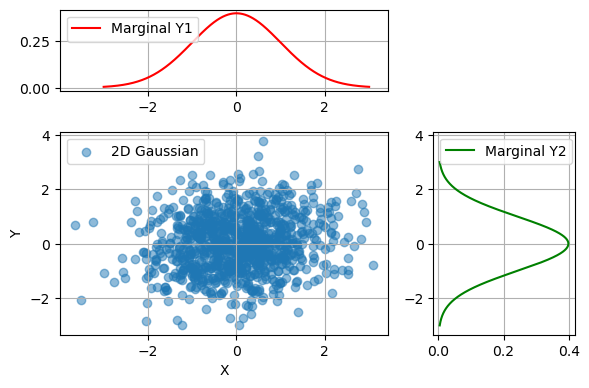

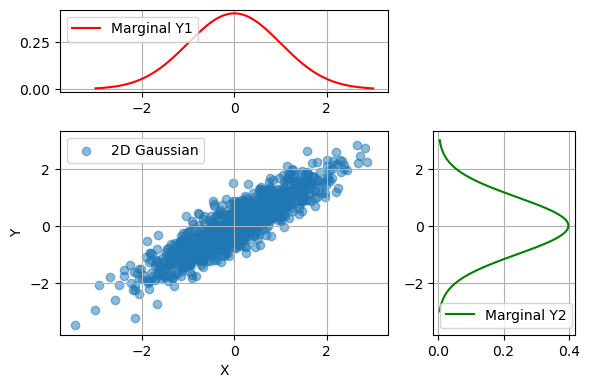

In [127]:
def plot_2d_gp(mu1, mu2, rho=0, sigma1=1, sigma2=1):
    mu = np.array([mu1, mu2])  # mean
    covariance = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma1*sigma2, sigma2**2]]) # covariance matrix

    # Generate data points from the 2D Gaussian distribution
    num_samples = 1000
    data = np.random.multivariate_normal(mu, covariance, num_samples)

    # Calculate marginal distributions
    y_values = np.linspace(-3, 3, 1000)
    marginal_y1 = norm.pdf(y_values, loc=mu[0], scale=np.sqrt(covariance[0, 0]))
    marginal_y2 = norm.pdf(y_values, loc=mu[1], scale=np.sqrt(covariance[1, 1]))

    # Create figure and gridspec
    fig = plt.figure(figsize=(6, 4))
    gs = fig.add_gridspec(3, 3)

    # Main plot (2D Gaussian distribution)
    ax_main = fig.add_subplot(gs[1:3, :2])
    ax_main.scatter(data[:, 0], data[:, 1], alpha=0.5, label='2D Gaussian')
    ax_main.set_xlabel('X')
    ax_main.set_ylabel('Y')
    ax_main.legend()
    ax_main.grid(True)

    # Marginal X plot
    ax_marginal_x = fig.add_subplot(gs[0, :2], sharex=ax_main)
    ax_marginal_x.plot(y_values, marginal_y1, label='Marginal Y1', color='r')
    ax_marginal_x.legend()
    ax_marginal_x.grid(True)

    # Marginal Y plot
    ax_marginal_y = fig.add_subplot(gs[1:3, 2], sharey=ax_main)
    ax_marginal_y.plot(marginal_y2, y_values, label='Marginal Y2', color='g')
    ax_marginal_y.legend()
    ax_marginal_y.grid(True)

    plt.tight_layout()
    plt.show()

# Parameters for the 2D Gaussian distribution
mu1 = 0
mu2 = 0

# How does the distribution change with different values of rho?
for rho in np.linspace(0.1,0.9, 2):
    plot_2d_gp(mu1, mu2, rho)

### $d>2$

```{margins}
This great visualisation idea I borrowed from Darren Wilkinson's slides from the GPSS.
```

Visualising the distribution in dimensions higher than 2 is harder. 

Still in 2d, we can use indices of components of $y$ - 1 for $y_1$ and 2 for $y_2$ to make the plots. 

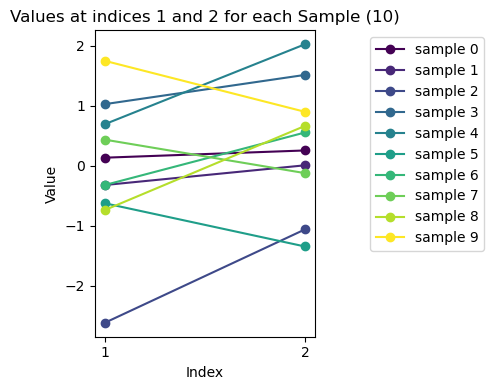

In [134]:

# Parameters for the 2D Gaussian distribution
mu = np.array([0, 0])  # mean
covariance = np.array([[1, 0.5], [0.5, 1]])  # covariance matrix

num_samples = 10
data = np.random.multivariate_normal(mu, covariance, num_samples)

# Extract values at indices 1 and 2 for each sample
index_1 = 1
index_2 = 2
values_1 = data[:, index_1 - 1]
values_2 = data[:, index_2 - 1]

# Generate a color map
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_samples - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Plotting
plt.figure(figsize=(3, 4))

for i in range(num_samples):
    color = scalar_map.to_rgba(i)
    plt.plot([1, 2], [values_1[i], values_2[i]], color=color, marker='o', linestyle='-', label=f'sample {i}')

plt.xticks([1, 2], ['1', '2'])  # Set x-axis ticks to only 1 and 2
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Values at indices 1 and 2 for each Sample ({num_samples})')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
plt.show()


Can we generalise this approach to visualise data of higher dimensionality $d$?

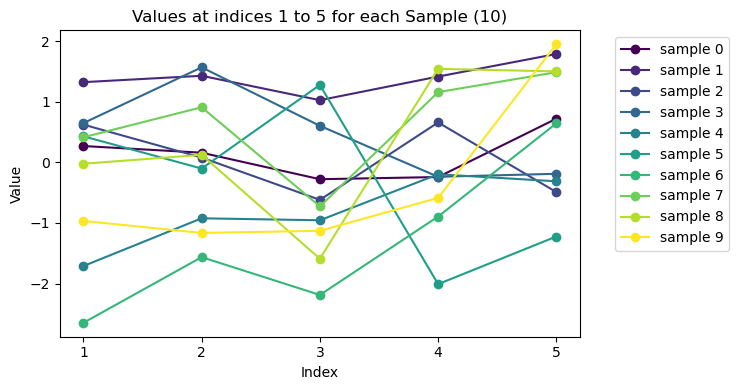

In [200]:
def plot_values(data, d):
    num_samples = data.shape[0]
    indices = list(range(1, d + 1))  # Indices to plot
    values = [data[:, idx - 1] for idx in indices]

    # Generate a color map
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=num_samples - 1)
    scalar_map = ScalarMappable(norm=norm, cmap=cmap)

    # Plotting
    plt.figure(figsize=(6, 4))

    for i in range(num_samples):
        color = scalar_map.to_rgba(i)
        plt.plot(indices, [values[j][i] for j in range(len(indices))], color=color, marker='o', linestyle='-', label=f'sample {i}')

    plt.xticks(indices, [str(idx) for idx in indices])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Values at indices 1 to {d} for each Sample ({num_samples})')
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

# Parameters for the multivariate Gaussian distribution
mu = np.zeros(5)  # mean vector
covariance = np.array([[1,    0.8,  0.7, 0.4, 0.1],
                       [0.8,    1,  0.5, 0.3, 0.2],
                       [0.7,   0.5,    1, 0.2, 0.1],
                       [0.4,   0.3,  0.2,   1, 0.1],
                       [0.1,   0.2,  0.1, 0.1,   1]])  # Example non-trivial covariance matrix

# Generate data from multivariate normal distribution
d = 5  # Number of components in the vector
num_samples = 10
data = np.random.multivariate_normal(mu, covariance, num_samples)
plot_values(data, d)


In the example above we coded up the covariance matris by hand. It is time to look into what covariance matrices might be more meaningful.

## Gaussian process

**Definition** (stochastic process)

A stochastic process is a collection of random variables $f=f(x)$ indexed by some variable $x \in \mathbb{X}$.

**Definition** (Gaussian processes)

A **Gaussian process** is a stochastic process over the function $f: \mathbb{X} \to \mathbb{R}$, such that every finite realisation $ (y_1, ..., y_d)T$ follows a Gaussian (multivariate normal) dsitribution:

$$
(f(x_1), ... , f(x_d))^T \sim \mathcal{N}\left( \mu, \Sigma \right).
$$


To fully specify a Gaussian process, we need to specify its **mean function** $\mu(x)$ and its **covariance function** $k(x,x'):$

$$f(x) \sim \mathcal{GP}(\mu(x), k(x, x')),$$

where

$$\mathbb{E}[f(x)]=\mu(x)$$

and 

$$\text{cov}[f(x), f(x')]=k(x, x').$$

### Mean function

Typically, for the mean function we chose one of the following options

- $\mu(x)=0,$
- $\mu(x)=c,$
- $\mu(x)=\beta^Tx$.

### Covariance functions (or kernels)

Covariance function must be a positive semi-definite function in order to lead to valid covariance matrices.

**Definition** (kernel)

$k: \mathbb{X} \times \mathbb{X} \to \mathbb{R}$ is a positive definite **kernel**, if for any finite collection $x= (x_1, ..., x_d)$ the matrix $k_{xx}$ with $[k_{xx}]_{ij}=k(x_i, x_j)$ is **positive definite**.

**Definition** (positive definite matrix)

A symmetric matrix $A \in \mathbb{R}^{N \times N}$ is called positve (semi-) definite if
$$v^T A v \ge 0$$ 
for any $v \in \mathbb{R}^N.$

## Kernels

Kernel functions $k(x, x′)$ encode prior beliefs of data-generating latent functions. These typically include
- continuity,
- smomothness (differentialbility),
- periodicity,
- stationarity,

and so on.

The covariance functions typically have **hyperparameters** that we aim to learn from data.



Let us explore some typical covariance functions.

### RBF

The squared exponential kernel, also known as the Gaussian kernel or the radial basis function (RBF) kernel is one of the most commonly used kernels in Gaussian process regression. It is defined as

$$k(x_i, x_j) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \|x_i - x_j\|^2 \right)$$

where

- $\sigma^2$ is the variance parameter (also called the amplitude),
- $l$ is the lengthscale parameter,
- $\|x_i - x_j\|$ is the Euclidean distance between the points $x_i$ and $x_j$.

This kernel assigns high similarity (and hence high covariance) to points that are close to each other in the input space and low similarity (and low covariance) to points that are far apart. The parameters $\sigma^2$ and $l$ control the overall variance and the rate at which the covariance decreases with distance, respectively.



In [225]:
def rbf_kernel(x1, x2, sigma=1.0, lengthscale=1.0, jitter=1e-6):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    K += jitter * jnp.eye(K.shape[0])  # Add jitter to ensure positive definiteness
    return K

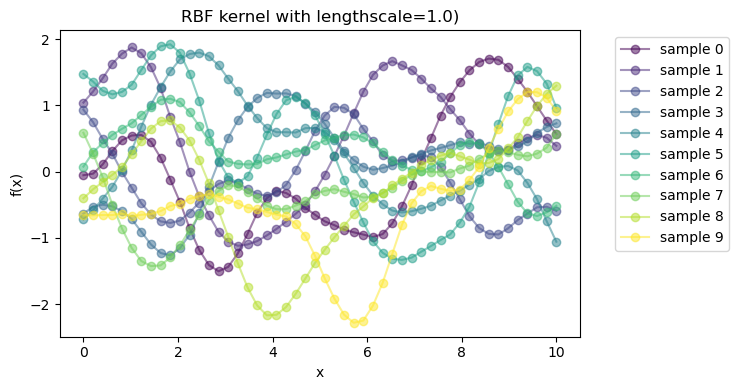

In [228]:
# Define parameters
n_points = 50
num_samples = 10
sigma = 1.0
lengthscale = 1.0
jitter = 1e-4

# Generate random input data
x = jnp.linspace(0, 10, n_points).reshape(-1, 1)

# Compute covariance matrix using RBF kernel function
K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

# Generate a color map
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_samples - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Parameters for the multivariate Gaussian distribution
mu = np.zeros(n_points)  # mean vector

data = np.random.multivariate_normal(mu, K, num_samples)

# Generate a color map
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_samples - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Plotting
plt.figure(figsize=(6, 4))

for i in range(num_samples):
    color = scalar_map.to_rgba(i)
    plt.plot(x, data[i,:], marker='o', linestyle='-', alpha=0.5, color=color, label=f'sample {i}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'RBF kernel with lengthscale={lengthscale})')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


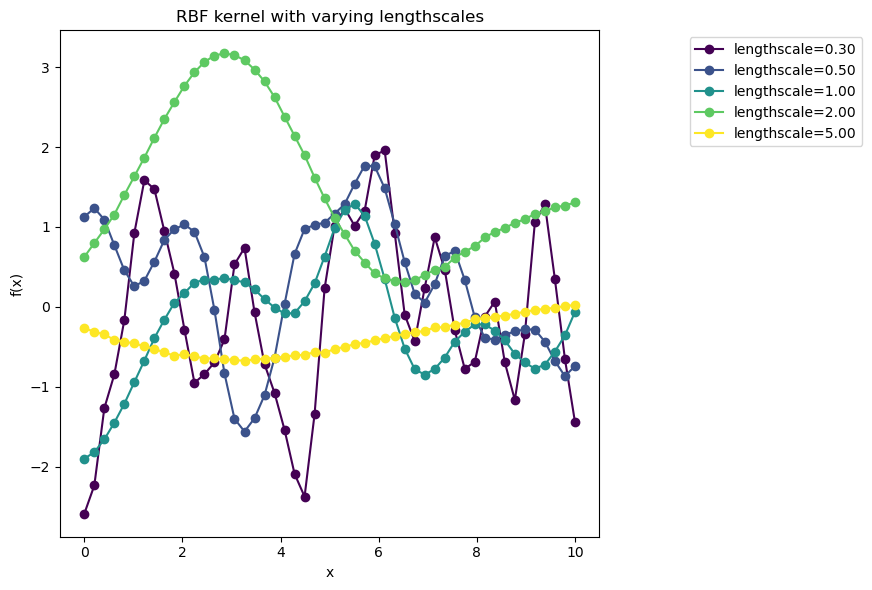

In [229]:
# Generate random lengthscale values for each sample
#lengthscales = np.linspace(0.1, 6, num_samples-1)
lengthscales = np.array([0.3,  0.5, 1.0, 2.0, 5.0])

# Plotting
plt.figure(figsize=(10, 6))

for i, lengthscale in enumerate(lengthscales):

    # Compute covariance matrix using RBF kernel function with different lengthscale for each sample
    K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

    # Draw samples from multivariate Gaussian distribution
    mu = np.zeros(n_points)  # mean vector
    data = np.random.multivariate_normal(mu, K)
    
    # Generate a color corresponding to the lengthscale
    color = cmap(i / (len(lengthscales) - 1))
    
    # Plot the sample
    plt.plot(x, data, marker='o', linestyle='-', color=color, label=f'lengthscale={lengthscale:.2f}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'RBF kernel with varying lengthscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.show()


Apart from visualising trajectories, we can also plot the covariance matrix:

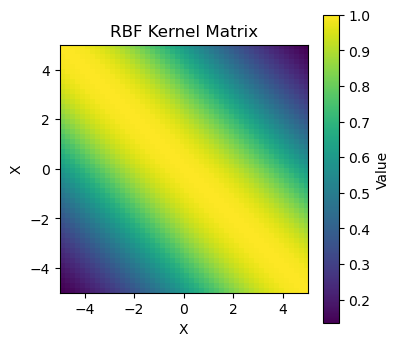

In [230]:
# Visualization
plt.figure(figsize=(4, 4))
plt.imshow(K, cmap='viridis', extent=[-5, 5, -5, 5])
plt.colorbar(label='Value')
plt.title('RBF Kernel Matrix')
plt.xlabel('X')
plt.ylabel('X')
plt.show()


We will need to plot many more GP trajectories.Let us write a helper function for that.

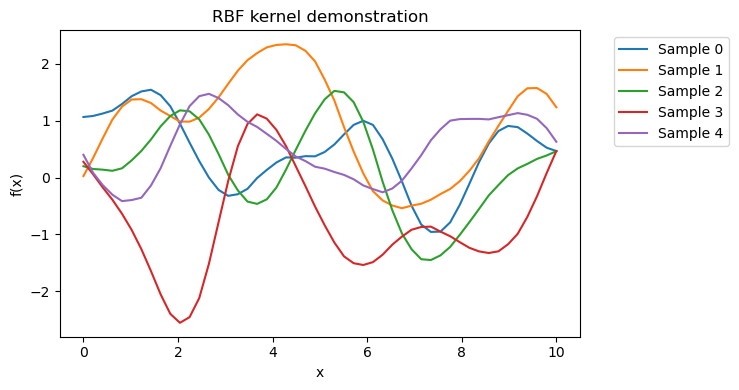

In [272]:
def plot_gp_samples(x, K, ttl="", num_samples=5):
    
    num_points = len(x)
    samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=K, size=num_samples)

    # Plot the samples
    plt.figure(figsize=(6, 4))
    for i in range(num_samples):
        plt.plot(x, samples[i], label=f'Sample {i}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

# test the function
n_points = 50
sigma = 1.0
lengthscale = 1.0
jitter = 1e-4

# Generate random input data
x = jnp.linspace(0, 10, n_points).reshape(-1, 1)

# Compute covariance matrix using RBF kernel function
K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

plot_gp_samples(x, K, ttl="RBF kernel demonstration")

### Matérn kernels

The Matérn kernel is another popular choice in Gaussian processes. It is a flexible covariance function that is able to capture different levels of smoothness in the data. The Matérn kernel is defined as:

$$
k_{\text{Matérn}}(x_i, x_j) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu}}{\ell} \|x_i - x_j\| \right)^\nu K_\nu \left( \frac{\sqrt{2\nu}}{\ell} \|x_i - x_j\| \right)
$$

where

- $k(x_i, x_j)$ represents the covariance between two data points $x_i$, $x_j$,
- $\sigma^2$ is the variance parameter,
- $\nu$ is the smoothness parameter, typically a positive half-integer or integer ($\nu = 1/2, 3/2, 5/2$),
- $l$ is the length-scale parameter,
- $\|x_i - x_j\|$ is the Euclidean distance between the points $x_i$ and $x_j$,
- $K_\nu$ is the modified Bessel function of the second kind of order $\nu$,
- $\Gamma$ is the gamma function.


### Matérn 3/2 and 5/2

The Matérn kernel with $\nu=3/2$ is a particular case of the Matérn family of kernels and is defined as

$$k_{\text{Matérn-3/2}}(x_i, x_j) = \sigma^2 \left(1 + \frac{\sqrt{3} \|x_i - x_j\|}{\ell}\right) \exp\left(-\frac{\sqrt{3} \|x_i - x_j\|}{\ell}\right).$$

The Matérn kernel with $\nu=5/2$ is another member of the Matérn family of kernels. The formula for the Matérn-5/2 kernel is given as

$$k_{\text{Matérn-5/2}}(x_i, x_j) = \sigma^2 \left(1 + \frac{\sqrt{5} \|x_i - x_j\|}{\ell} + \frac{5 \|x_i - x_j\|^2}{3\ell^2}\right) \exp\left(-\frac{\sqrt{5} \|x_i - x_j\|}{\ell}\right).$$



In [273]:
def matern32_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    Compute the Matérn-3/2 kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(3) * arg) * jnp.exp(- jnp.sqrt(3) * arg)

# Compile the kernel function for better performance
matern32_kernel = jit(matern32_kernel)


In [274]:
def matern52_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    Compute the Matérn-5/2 kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(5) * arg + 5/3 * arg**2) * jnp.exp(-jnp.sqrt(5) * arg)

# Compile the kernel function for better performance
matern52_kernel = jit(matern52_kernel)


### Periodic kernel

The periodic kernel is commonly used in Gaussian processes to model periodic patterns in data. The formula for the periodic kernel is given as

$$k_{\text{periodic}}(x_i, x_j) = \sigma^2 \exp \left( -\frac{2\sin^2(\pi\|x_i - x_j\|/p)}{\ell^2} \right)$$



In [275]:
def periodic_kernel(x1, x2, sigma=1.0, lengthscale=1.0, period=1.0):
    """
    Compute the periodic kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - period (float): Periodicity parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    return sigma**2 * jnp.exp(-2 * jnp.sin(jnp.pi * dist/ period)**2 / lengthscale**2)

# Compile the kernel function for better performance
periodic_kernel = jit(periodic_kernel)

### Linear kernel

The linear kernel, also known as the dot product kernel, is one of the simplest kernels used in machine learning and Gaussian processes. It computes the covariance between two data points as the inner product of their feature vectors. The formula for the linear kernel is given as

$$k_{\text{linear}}(x_i, x_j) = x_i^T x_j$$

In [277]:
def linear_kernel(x1, x2):
    """
    Compute the linear kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    return jnp.dot(x1, x2.T)

# Compile the kernel function for better performance
linear_kernel = jit(linear_kernel)


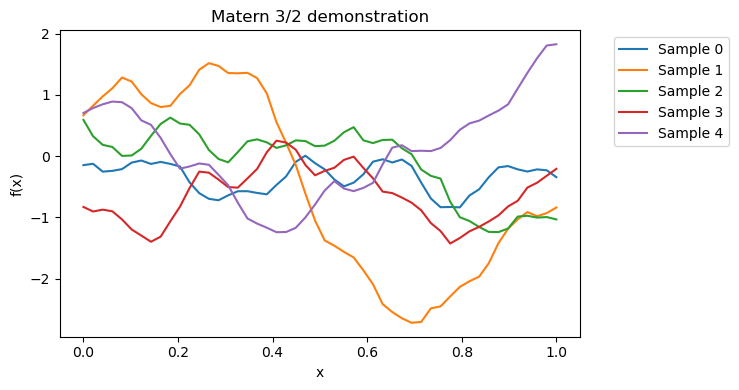

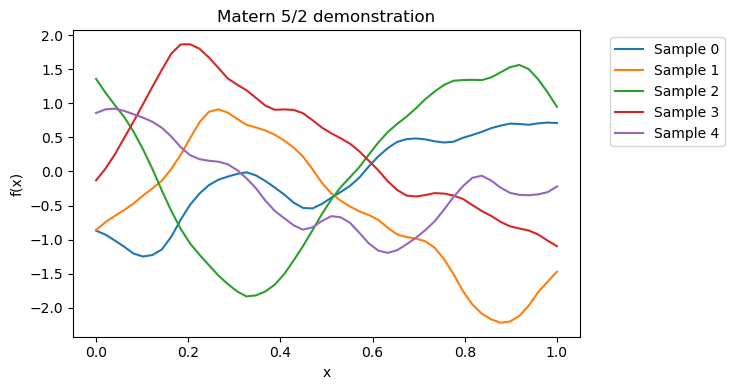

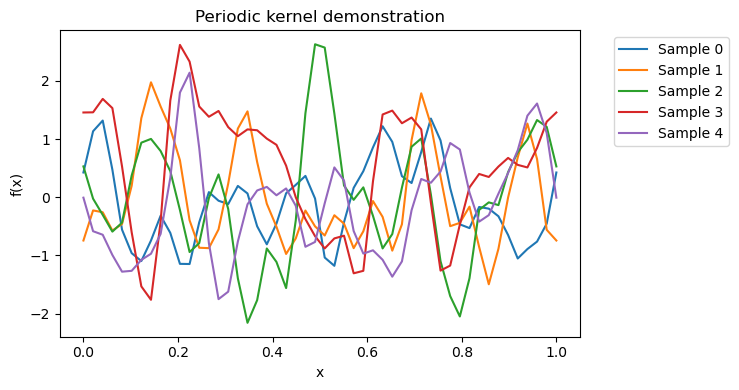

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_16849/3899070325.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=K, size=num_samples)


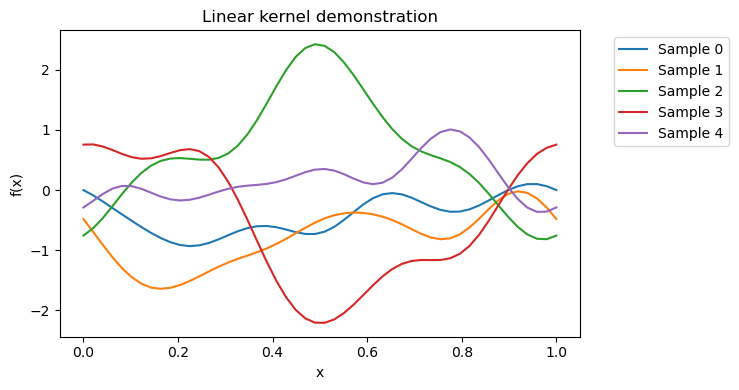

In [280]:
# test the function
n_points = 50
sigma = 1.0
lengthscale = 0.2
jitter = 1e-4

# Generate random input data
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

# Compute covariance matrix using RBF kernel function
K32 = matern32_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K52 = matern52_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K_per = periodic_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K_lin = periodic_kernel(x, x)

plot_gp_samples(x, K32, ttl="Matern 3/2 demonstration")
plot_gp_samples(x, K52, ttl="Matern 5/2 demonstration")
plot_gp_samples(x, K_per, ttl="Periodic kernel demonstration")
plot_gp_samples(x, K_lin, ttl="Linear kernel demonstration")

## Assignment

Implement rational quadratic kernel:
- plot function draws,
- plot covariance matrix


## Combining kernels

see my previous text here

https://github.com/elizavetasemenova/gp_turing/blob/main/gp_rbf.ipynb